In [2]:
%%capture
%load_ext autoreload
%autoreload 2
import os
import torch
import numpy as np
import pandas as pd
import math
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
np.exp(0)

In [3]:
k = np.array([
        [[0.5, -0.04], [0.6, 0.8], [0.7, -0.5], [0.8, 0.9]],       # Individual 0
        [[1.0, 0.82], [0.8, 0.76], [1.1, 0.7], [1.2, 0.6]],        # Individual 1
        [[1.3, -0.18], [0.7, 0.21], [0.9, 0.3]],                   # Individual 2
        [[1.5, 0.43], [0.9, 0.64], [1.0, 0.5]],                    # Individual 3
        [[1.2, 0.5], [1.3, 0.4]],                                  # Individual 4
        [[0.8, -0.2], [0.9, 0.1]]                                  # Individual 5
    ], dtype=object)
d = np.atleast_2d(k)
d

array([[list([[0.5, -0.04], [0.6, 0.8], [0.7, -0.5], [0.8, 0.9]]),
        list([[1.0, 0.82], [0.8, 0.76], [1.1, 0.7], [1.2, 0.6]]),
        list([[1.3, -0.18], [0.7, 0.21], [0.9, 0.3]]),
        list([[1.5, 0.43], [0.9, 0.64], [1.0, 0.5]]),
        list([[1.2, 0.5], [1.3, 0.4]]), list([[0.8, -0.2], [0.9, 0.1]])]],
      dtype=object)

In [39]:
# Generate synthetic data
data = make_simple_data(n_samples=10000)
X = data.drop(columns=["time", "event"]).values
times = data["time"].values
event = data["event"].values

In [40]:
# Initialize the Cox model
cox_model = CoxModel(X, event, times, lambda_reg=10)

# Fit the model and return the optimized coefficients
final_coefficients = cox_model.fit(n_iter=20, verbose=True)

Optimization Progress:   0%|                                                 | 0/20 [00:00<?, ?it/s]


Iteration 5: Coefficients = [1.0119871  2.01295207 0.00752443 0.00392907]
Gradient Norm: 3.179572263912692e-07
Delta Norm: 1.7700102766027e-06
Early stopping at iteration 9.
Final optimized coefficients: [1.0119871  2.01295207 0.00752443 0.00392907]


In [ ]:
from surv_optimizer.CoxPlotHelper import CoxPlotHelper

# Initialize the plot helper with optimizer, beta values, and time range
plot_helper = CoxPlotHelper(cox_model, final_coefficients)

plot_helper.plot_survival_and_hazard()

In [11]:
# Generate synthetic data
data = make_transition_data(n_samples=3)
data

,individual,time,state,sojourn_time,censorship,x1,x2,y1,y2
0,0,86.460952,1,70.055504,1,0.657593,-0.890878,1.756089,2.060344
1,1,0.004385,1,0.002337,1,1.000000,1.000000,-0.418076,-0.365264
2,2,134.049209,1,134.049209,0,-1.000000,-1.000000,-1.998441,-2.021617
3,2,391.854249,0,257.805040,0,-1.000000,-1.000000,-1.901029,-1.926311
4,2,2326.987013,1,345.674435,1,-1.000000,-1.000000,-1.927859,-1.969975


In [63]:
# Extract event indicator for transition from state 1 to state 2
delta_i1 = data['event'].values

# Extract covariates Z_{i1} for each individual for transition from state 1 to state 2
Z_i1 = data[[col for col in data.columns if col.startswith("x")]].values

# Extract time-dependent covariates Z_{ij1} for each individual for transition from state 1 to state 2
Z_ij1 = data[['sojourn_time']].values  # Assuming covariate_1 and covariate_2 represent Z_{ij1}

# At-risk indicator Y_{l1}(t), 1 if individual is in state 1 at time t
Y_l1_t = (data['from_state'] == 1).astype(int).values
n_covariates = Z_i1.shape[1]  # Number of covariates (columns in Zij_t)
beta_j = np.random.randn(n_covariates)  # Generate random coefficients for each covariate

In [81]:
import numpy as np

# Define a large set of linear predictors, simulating 1000 values that are quite large
np.random.seed(42)
xw = np.random.normal(1000, 1, 1000)  # Mean of 1000, standard deviation of 1

# Naive computation without shifting
def naive_log_sum_exp(x):
    exp_x = np.exp(x)  # This can lead to overflow for large values
    return np.log(np.sum(exp_x))

# Stable computation with shifting (log-sum-exp trick)
def stable_log_sum_exp(x):
    max_x = np.max(x)
    shifted_x = x - max_x
    exp_shifted_x = np.exp(shifted_x)
    return np.log(np.sum(exp_shifted_x)) + max_x

# Perform both computations
try:
    naive_result = naive_log_sum_exp(xw)
except OverflowError:
    naive_result = "Overflow"

stable_result = stable_log_sum_exp(xw)

# Print the results
print("Naive Log-Sum-Exp Result (may overflow):", naive_result)
print("Stable Log-Sum-Exp Result:", stable_result)

# Verify accuracy by comparing the stable result to a smaller-scale version
# Reduce the values in xw to avoid overflow, and compare the stable computation
xw_small = xw - 1000  # Shift values down to a smaller range, centered around 0
expected_result = stable_log_sum_exp(xw_small) + 1000

print("Expected Log-Sum-Exp Result (scaled back):", expected_result)
print("Difference between stable and expected result:", abs(stable_result - expected_result))

Naive Log-Sum-Exp Result (may overflow): inf
Stable Log-Sum-Exp Result: 3.575205995532959
Expected Log-Sum-Exp Result (scaled back): 1003.575205995533
Difference between stable and expected result: 1000.0


C:\Users\runet\AppData\Local\Temp\ipykernel_22048\599472724.py:9: RuntimeWarning: overflow encountered in exp
  exp_x = np.exp(x)  # This can lead to overflow for large values


Concordance Index: 0.83


C:\Users\runet\PycharmProjects\survival_analysis\.venv\lib\site-packages\lifelines\utils\__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]
C:\Users\runet\PycharmProjects\survival_analysis\.venv\lib\site-packages\lifelines\utils\__init__.py:1157: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in df.iteritems():
C:\Users\runet\PycharmProjects\survival_analysis\.venv\lib\site-packages\lifelines\fitters\coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.548. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


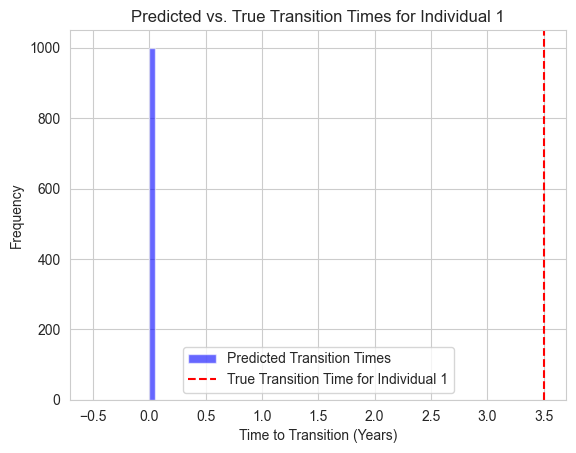

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

# Step 1: Set Up Data
# Create a toy dataset of individuals with covariates and observed transition times
data = pd.DataFrame({
    'age': [45, 50, 60, 65, 70],
    'smoker': [0, 1, 1, 0, 1],
    'time': [5, 4, 3, 6, 2],  # Time to transition (in years)
    'event': [1, 1, 1, 1, 1]  # All individuals transitioned
})

# Fit a Cox model to this data
cph = CoxPHFitter()
cph.fit(data, duration_col='time', event_col='event')

# Step 2: Monte Carlo Simulation to Predict Transitions for Multiple Individuals
# Define parameters for the Monte Carlo simulation
n_simulations = 1000  # Number of simulations to run
individuals_data = [
    {'age': 55, 'smoker': 1, 'true_time': 3.5},  # First individual
    {'age': 60, 'smoker': 0, 'true_time': 4.0},  # Second individual
    {'age': 65, 'smoker': 1, 'true_time': 2.5},  # Third individual
]
predicted_times = []

# Loop through each individual and run Monte Carlo simulation
for individual in individuals_data:
    sample_covariates = np.array([individual['age'], individual['smoker']])
    partial_hazard = np.exp(np.dot(sample_covariates, cph.params_.values))
    baseline_hazard = cph.baseline_hazard_.values.flatten()
    cumulative_baseline_hazard = np.cumsum(baseline_hazard)

    simulated_paths = []
    for _ in range(n_simulations):
        eps = np.random.uniform()
        survival_probs = np.exp(-cumulative_baseline_hazard * partial_hazard)

        transition_time = np.where(survival_probs <= eps)[0]
        if len(transition_time) > 0:
            simulated_paths.append(transition_time[0])
        else:
            simulated_paths.append(len(survival_probs))  # No transition observed in simulated period

    # Calculate median of predicted transition times
    predicted_time = np.median(simulated_paths)
    predicted_times.append(predicted_time)

# Step 3: Concordance Index Calculation
# Prepare data for concordance index calculation
true_times = [individual['true_time'] for individual in individuals_data]

data_for_ci = pd.DataFrame({
    'age': [individual['age'] for individual in individuals_data],
    'smoker': [individual['smoker'] for individual in individuals_data],
    'predicted_time': predicted_times,
    'true_time': true_times
})

# Calculate the concordance index
ci = concordance_index(data_for_ci['true_time'], data_for_ci['predicted_time'])
print(f'Concordance Index: {ci:.2f}')

# Step 4: Plot Predicted vs. True Transition Times
# Plot the distribution of predicted transition times for one of the individuals
plt.hist(simulated_paths, bins=20, alpha=0.6, color='b', label='Predicted Transition Times')
plt.axvline(x=individuals_data[0]['true_time'], color='r', linestyle='--', label='True Transition Time for Individual 1')

plt.xlabel('Time to Transition (Years)')
plt.ylabel('Frequency')
plt.title('Predicted vs. True Transition Times for Individual 1')
plt.legend()
plt.show()

   individual_id from_state to_state  transition_time
0              0          C        C                1
1              2          C        A                1
2              4          A        C                4


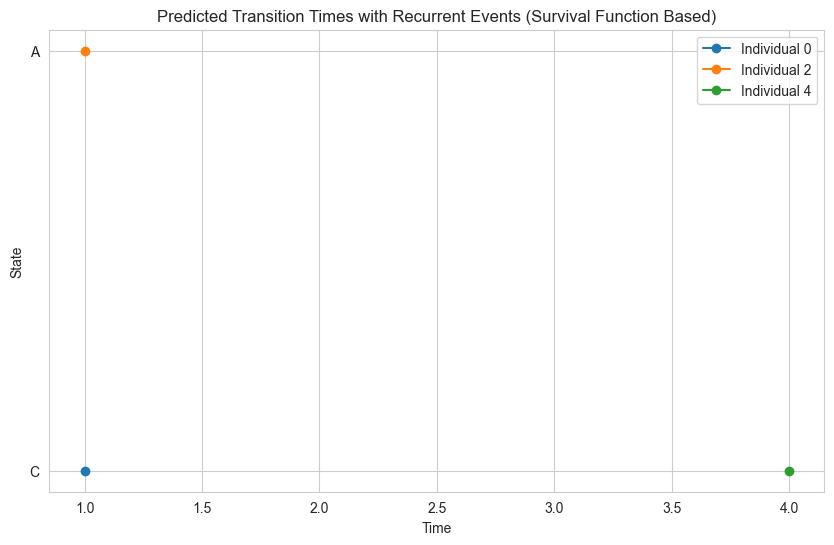

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create a toy dataset with initial states and covariates for 5 individuals
np.random.seed(42)
n_individuals = 5
data = pd.DataFrame({
    'individual_id': range(n_individuals),
    'initial_state': np.random.choice(['A', 'B', 'C'], size=n_individuals),
    'covariate_1': np.random.normal(0, 1, n_individuals),
    'covariate_2': np.random.normal(0, 1, n_individuals)
})

# Define transition probabilities between states A, B, and C
transition_probs = {
    'A': {'A': 0.1, 'B': 0.6, 'C': 0.3},
    'B': {'A': 0.3, 'B': 0.4, 'C': 0.3},
    'C': {'A': 0.5, 'B': 0.2, 'C': 0.3}
}

# Define baseline hazard and cumulative hazard for demonstration purposes
baseline_hazard = np.array([0.02, 0.025, 0.03, 0.04, 0.05])
cumulative_baseline_hazard = np.cumsum(baseline_hazard)

# Monte Carlo simulation to predict transition times with recurrent events
def monte_carlo_simulation(individual, initial_state, covariates, max_transitions=10):
    current_state = initial_state
    current_time = 0
    transitions = []

    # Calculate partial hazard based on covariates
    partial_hazard = np.exp(np.dot(covariates, [0.5, -0.3]))  # Example coefficients for covariates

    # Calculate individual-specific cumulative hazard
    individual_cumulative_hazard = cumulative_baseline_hazard * partial_hazard

    for _ in range(max_transitions):
        # Use survival function to determine the time to the next transition
        survival_probs = np.exp(-individual_cumulative_hazard)
        transition_prob = 1 - survival_probs

        # Predict transition time by selecting the first time where the transition occurs
        transition_occurred = np.random.uniform() < transition_prob
        if not transition_occurred.any():
            break

        # Get the index of the first transition occurrence
        transition_index = np.argmax(transition_occurred)
        time_to_next = transition_index + 1  # Assume each step is 1 unit of time
        current_time += time_to_next

        # Choose the next state based on transition probabilities
        next_state = np.random.choice(
            list(transition_probs[current_state].keys()),
            p=list(transition_probs[current_state].values())
        )

        # Record the transition
        transitions.append({
            'individual_id': individual,
            'from_state': current_state,
            'to_state': next_state,
            'transition_time': current_time
        })

        # Update the current state
        current_state = next_state

    return transitions

# Run the Monte Carlo simulation for each individual to predict recurrent transitions
all_transitions = []
for i in range(n_individuals):
    individual_transitions = monte_carlo_simulation(
        individual=data.loc[i, 'individual_id'],
        initial_state=data.loc[i, 'initial_state'],
        covariates=data.loc[i, ['covariate_1', 'covariate_2']].values
    )
    all_transitions.extend(individual_transitions)

# Create a DataFrame with all the predicted transitions
transitions_df = pd.DataFrame(all_transitions)

# Print the transition DataFrame to show predicted transition times with recurrence
print(transitions_df)

# Plot the predicted transition times for each individual
plt.figure(figsize=(10, 6))
for individual in transitions_df['individual_id'].unique():
    individual_transitions = transitions_df[transitions_df['individual_id'] == individual]
    plt.plot(individual_transitions['transition_time'], individual_transitions['to_state'], marker='o', label=f'Individual {individual}')

plt.xlabel('Time')
plt.ylabel('State')
plt.title('Predicted Transition Times with Recurrent Events (Survival Function Based)')
plt.legend()
plt.show()

Population-level Transition Probabilities:
[[0. 1.]
 [1. 0.]]


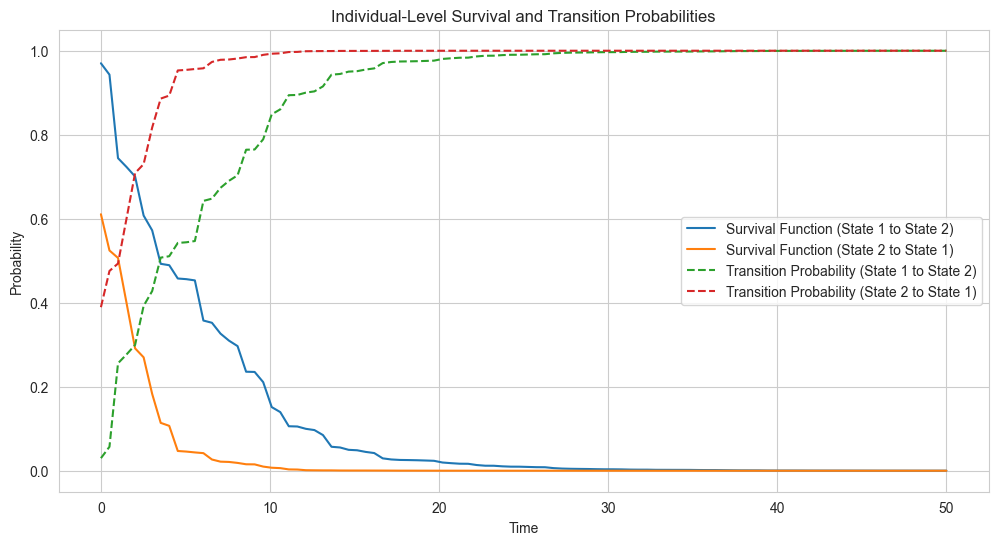

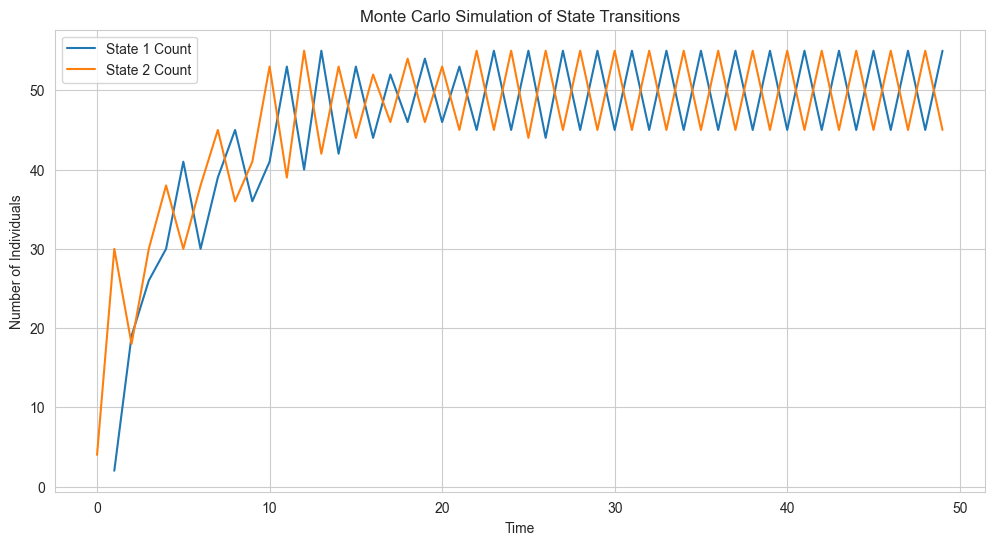

In [8]:
import numpy as np
import pandas as pd

# Seed for reproducibility
np.random.seed(42)

# Number of individuals and number of observations per individual
n_individuals = 100
max_transitions_per_individual = 10
max_time = 50
# Generate data with more variability in state transitions
data = []

for i in range(n_individuals):
    current_state = 1  # Start in state 1
    time = 0
    for _ in range(max_transitions_per_individual):
        # Generate random sojourn time
        sojourn_time = np.random.exponential(scale=5)
        time += sojourn_time

        # Append the current observation
        data.append({'individual': i, 'time': time, 'state': current_state})

        # Randomly decide whether to switch state or stay in the current state
        if np.random.rand() < 0.3:  # 50% chance to transition
            current_state = 3 - current_state  # Switch between state 1 and state 2

# Create DataFrame
df = pd.DataFrame(data)

# Step 2: Calculate population-level transition probabilities
# Assume we have two states: 1 (Healthy) and 2 (Hospitalized)
population_transition_counts = np.zeros((2, 2))

for i in range(n_individuals):
    individual_data = df[df['individual'] == i].sort_values(by='time')  # Sort data by time
    prev_state = 1  # All individuals start in state 1

    # Iterate over each row for the individual's transitions
    for _, row in individual_data.iterrows():
        current_state = int(row['state'])  # Ensure state is cast to an integer
        if prev_state in [1, 2] and current_state in [1, 2] and prev_state != current_state:
            population_transition_counts[prev_state - 1, current_state - 1] += 1
        prev_state = current_state  # Update previous state to current state for next iteration

# Calculate population-level transition probabilities
# To avoid division by zero, set transition probabilities to zero for rows with no transitions
with np.errstate(divide='ignore', invalid='ignore'):
    population_transition_probabilities = np.nan_to_num(population_transition_counts / 
                                                        population_transition_counts.sum(axis=1, keepdims=True))

print("Population-level Transition Probabilities:")
print(population_transition_probabilities)

# Step 3: Calculate individual-level transition probabilities
def survival_function(cumulative_hazard):
    return np.exp(-cumulative_hazard)

time_bins = np.linspace(0, max_time, 100)
cumulative_hazard_1_to_2 = np.cumsum(np.random.exponential(scale=0.1, size=len(time_bins)))
cumulative_hazard_2_to_1 = np.cumsum(np.random.exponential(scale=0.2, size=len(time_bins)))

survival_1_to_2 = survival_function(cumulative_hazard_1_to_2)
survival_2_to_1 = survival_function(cumulative_hazard_2_to_1)

individual_transition_prob_1_to_2 = 1 - survival_1_to_2
individual_transition_prob_2_to_1 = 1 - survival_2_to_1

# Plot the survival functions and individual-level transition probabilities
plt.figure(figsize=(12, 6))
plt.plot(time_bins, survival_1_to_2, label='Survival Function (State 1 to State 2)')
plt.plot(time_bins, survival_2_to_1, label='Survival Function (State 2 to State 1)')
plt.plot(time_bins, individual_transition_prob_1_to_2, linestyle='--', label='Transition Probability (State 1 to State 2)')
plt.plot(time_bins, individual_transition_prob_2_to_1, linestyle='--', label='Transition Probability (State 2 to State 1)')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Individual-Level Survival and Transition Probabilities')
plt.legend()
plt.show()

# Step 4: Monte Carlo Simulation for Multiple Transitions
n_simulations = 100
simulation_results = []

for sim in range(n_simulations):
    current_state = 1
    current_time = 0
    path = []
    while current_time < max_time:
        if current_state == 1:
            # Get transition probability for individual-level state 1 to state 2
            transition_prob = np.interp(current_time, time_bins, individual_transition_prob_1_to_2)
            if np.random.uniform() < transition_prob:
                current_state = 2
                path.append((current_time, current_state))
        elif current_state == 2:
            # Get transition probability for individual-level state 2 to state 1
            transition_prob = np.interp(current_time, time_bins, individual_transition_prob_2_to_1)
            if np.random.uniform() < transition_prob:
                current_state = 1
                path.append((current_time, current_state))
        current_time += 1  # Increment time step
    simulation_results.append(path)

# Convert simulation results to DataFrame for analysis
simulation_data = []

for i, path in enumerate(simulation_results):
    for time, state in path:
        simulation_data.append({'simulation': i, 'time': time, 'state': state})

simulation_df = pd.DataFrame(simulation_data)

# Plot number of individuals in each state over time
plt.figure(figsize=(12, 6))
for state in [1, 2]:
    state_counts = simulation_df[simulation_df['state'] == state].groupby('time').size()
    plt.plot(state_counts.index, state_counts.values, label=f'State {state} Count')

plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title('Monte Carlo Simulation of State Transitions')
plt.legend()
plt.show()